**DICOM to NifTI converter** - didn't work well (had to rerun on Linux computer)

This scrips uses dcm2niix (https://github.com/rordenlab/dcm2niix/releases) converter

In [1]:
import matplotlib.patheffects as path_effects
import matplotlib.pyplot as plt
import nibabel
import numpy as np

import mne
from mne.io.constants import FIFF
from mne.transforms import apply_trans

%matplotlib qt

import pandas as pd
import numpy as np
import os
from utils import check_paths


__________________

EXTRACT FILES FROM ARCHIVES

In [ ]:
fs_dir = 'D:\\BonoKat\\research project\\# study 1\\mri_data\\fs_output\\freesurfer\\sub_dir'
print(fs_dir)

In [ ]:
import os
import tarfile

#! sub07 was faulty (had many subfolders in the archive), beeded manual extraction
# DONE!

# Base directory containing subject folders or archives
fs_dir = 'D:\\BonoKat\\research project\\# study 1\\mri_data\\fs_output\\freesurfer\\sub_dir'
groups = ["Y", "O"]

for group in groups:
    base_dir = os.path.join(fs_dir, group)

    # List all items in the directory
    for file_name in os.listdir(base_dir):

        # Construct the full file path
        file_path = os.path.join(base_dir, file_name)

        # Check for tar or zip archive
        if file_name.endswith('.tar') or file_name.endswith('.tar.gz'):
            sub_name = os.path.splitext(os.path.splitext(file_name)[0])[0]  # removes .tar/.gz
            # extract_dir = os.path.join(base_dir, sub_name)
            
            os.makedirs(base_dir, exist_ok=True)
            print(f'Extracting {file_name} to {base_dir}...')

            with tarfile.open(file_path, 'r') as tar:
                tar.extractall(path=base_dir)

print('All archives processed.')


_____________________________

**Sanity check: visualisation of FS files**

In [67]:
# subjects_dir = 'D:\\BonoKat\\research project\\# study 1\\mri_data\\Y\\fs'
subjects_dir = 'D:\\BonoKat\\research project\\# study 1\\mri_data\\fs_output\\freesurfer\\sub_dir\\Y'
subject = "s1_pac_sub01"
t1_fname = os.path.join(subjects_dir, subject, "mri", "T1.mgz")
t1 = nibabel.load(t1_fname)
t1.orthoview()

<OrthoSlicer3D: D:/BonoKat/research project/# study 1/mri_data/fs_output/freesurfer/sub_dir/Y/s1_pac_sub01/mri/T1.mgz (256, 256, 256)>

Traceback (most recent call last):
  File "d:\BonoKat\research project\motor_pac\venv\Lib\site-packages\matplotlib\cbook.py", line 298, in process
    func(*args, **kwargs)
TypeError: OrthoSlicer3D._cleanup() takes 1 positional argument but 2 were given


In [ ]:
Brain = mne.viz.get_brain_class()
brain = Brain(
    subject, hemi="lh", surf="pial", subjects_dir=subjects_dir, size=(800, 600)
)
brain.add_annotation("aparc.a2009s", borders=False)

__________________________________

CHECK BEM SURFACES

In [ ]:
bem_path = os.path.join(subjects_dir, subject, 'bem', f"{subject}-head.fif")
surfaces = mne.read_bem_surfaces(bem_path)

In [70]:
import mne
from mne.datasets import fetch_fsaverage

# Try reading a cortical surface (e.g., lh.pial)
surf_path = f"{subjects_dir}/{subject}/surf/lh.pial"
coords, faces = mne.read_surface(surf_path)
print(f"✅ Surface loaded. Vertices: {len(coords)}, Faces: {len(faces)}")


✅ Surface loaded. Vertices: 134495, Faces: 268986


In [32]:
# Test a cortical surface
coords, faces = mne.read_surface(f"{subjects_dir}/{subject}/surf/lh.pial")
print(f"✅ lh.pial loaded: {len(coords)} vertices, {len(faces)} faces")

✅ lh.pial loaded: 134495 vertices, 268986 faces


___

GROUP ANALYSIS

In [ ]:
# SET EEG MONTAGE FROM DIGITIZER FILES
# DONE

eeg_data_dir = 'D:\\BonoKat\\research project\\# study 1\\eeg_data\\set'

groups = ['Y', 'O']
tasks = ['_BL', '_MAIN']
task_stages = ['_plan', '_go']
block_names = ['_baseline', '_adaptation']

for group in groups:
    dig_folder = f'D:\\BonoKat\\research project\\# study 1\\dig_data\\files for analysis\\{group}'
    dig_group_dir = os.path.join(eeg_data_dir, group)
    subjects_dir = os.path.join(eeg_data_dir, group)

    for subject in os.listdir(subjects_dir):
        eeg_sub_path = os.path.join(eeg_data_dir, group, subject)
        analysis_path = os.path.join(eeg_sub_path, 'preproc', 'analysis')
        source_path = os.path.join(analysis_path, 'source')
        check_paths(source_path)

        ######## ADJUST DIGITIZER FILES AND CREATE MONTAGE ########
        dig_file = os.path.join(dig_folder, f"{subject}.txt")

        # Set the header line
        column_names = ['Electrode Name', 'Electrode Type', 'Session Name', 'Loc. X', 'Loc. Y', 'Loc. Z', 'm0n0', 'm0n1', 'm0n2', 'm1n0', 'm1n1', 'm1n2', 'm2n0', 'm2n1', 'm2n2']
        cols_to_drop = ['m0n0', 'm0n1', 'm0n2', 'm1n0', 'm1n1', 'm1n2', 'm2n0', 'm2n1', 'm2n2']

        # Load the data, skipping the header lines
        dig_points_df = pd.read_csv(dig_file, names=column_names, sep='\t', comment='#').iloc[:-1]
        dig_points_df.drop(columns=cols_to_drop, inplace=True) # Drop electrode orientaiton columns
        dig_points_df['Electrode Type'] = dig_points_df['Electrode Type'].replace('Session 1', 'fiducial') # Set 'fiducial'as electrode type
        dig_points_df = dig_points_df.drop(columns=['Session Name']) # Drop the 'Session Name' column
        dig_points_df = dig_points_df.dropna() # Drop rows with any NaN values

        # Convert mm to m
        dig_points_df[['Loc. X', 'Loc. Y', 'Loc. Z']] = dig_points_df[['Loc. X', 'Loc. Y', 'Loc. Z']].astype(float).values / 1000 

        # EEG electrodes
        eeg_df = dig_points_df[dig_points_df['Electrode Type'] == 'EEG']
        eeg_pos = dict(zip(
            eeg_df['Electrode Name'],
            np.vstack([eeg_df['Loc. X'], eeg_df['Loc. Y'], eeg_df['Loc. Z']]).T
        ))

        # Fiducials
        fid_df = dig_points_df[dig_points_df['Electrode Type'] == 'fiducial']
        fid_pos = {row['Electrode Name'].lower(): [row['Loc. X'], row['Loc. Y'], row['Loc. Z']]
                for _, row in fid_df.iterrows()}

        # Lowercase the montage keys to match MNE style
        montage_renamed = {
            k.strip().capitalize(): v for k, v in eeg_pos.items()
        }
        # Create montage
        montage = mne.channels.make_dig_montage(
            ch_pos=eeg_pos,
            # nasion=fid_pos['nasion'], # removed fducials, since they do not allign with the positions of the electrodes
            # lpa=fid_pos['lpa'],
            # rpa=fid_pos['rpa'],
            coord_frame='head'  # 'mni_tal' / 'head' if Brainsight .txt file was used (preferable)
        )

        ######## READ ALL EPOCHS FILES AND SET MONTAGE ########
        # Loop through all task stages and blocks
        for task in tasks:
            for task_stage in task_stages:
                if task == '_BL':
                    epochs_file = os.path.join(analysis_path, f'{subject}{task}_epochs{task_stage}-epo.fif')
                    epochs = mne.read_epochs(epochs_file)
                    epochs.set_montage(montage, match_case=False)
                    epochs.save(os.path.join(source_path, f'{subject}{task}{task_stage}-epo_montage.fif'), overwrite=True)
                else:
                    for block_name in block_names:
                        epochs_file = os.path.join(analysis_path, f'{subject}{task}_epochs{task_stage}{block_name}-epo.fif')
                        epochs = mne.read_epochs(epochs_file)
                        epochs.set_montage(montage, match_case=False)
                        epochs.save(os.path.join(source_path, f'{subject}{task}{task_stage}{block_name}-epo_montage.fif'), overwrite=True)


In [ ]:
# MANUAL COREGISTRATION: 1 recording per subject
# DONE for younger group

group = 'Y'
task = '_BL'
task_stage = '_plan'
fs_subjects_dir = f'D:\\BonoKat\\research project\\# study 1\\mri_data\\fs_output\\freesurfer\\sub_dir\\{group}'
eeg_data_dir = 'D:\\BonoKat\\research project\\# study 1\\eeg_data\\set'
subjects_dir = os.path.join(eeg_data_dir, group)
subject = os.listdir(subjects_dir)[0] # change index to select a subject
print(f'Selecting subject: {subject}')

eeg_sub_path = os.path.join(eeg_data_dir, group, subject)
analysis_path = os.path.join(eeg_sub_path, 'preproc', 'analysis')
source_path = os.path.join(analysis_path, 'source')

info = os.path.join(source_path, f'{subject}{task}{task_stage}-epo_montage.fif')
mne.gui.coregistration(subject=subject,
                    subjects_dir=fs_subjects_dir,
                    inst=info,
                    )

# COREG CHECK
# trans_file = os.path.join(source_path, f'{subject}-trans.fif')
# trans = mne.read_trans(trans_file)
# mne.gui.coregistration(subject=subject,
#                     subjects_dir=fs_subjects_dir,
#                     inst=info,
#                     trans=trans_file
#                     )

In [ ]:
# CHECK COREGISTRATION
subject = os.listdir(subjects_dir)[0]
eeg_sub_path = os.path.join(eeg_data_dir, group, subject)
analysis_path = os.path.join(eeg_sub_path, 'preproc', 'analysis')
source_path = os.path.join(analysis_path, 'source')
epochs = mne.read_epochs(os.path.join(source_path, f'{subject}{task}{task_stage}-epo_montage.fif'))

trans_file = os.path.join(source_path, f'{subject}-trans.fif')
trans = mne.read_trans(trans_file)
# Here we look at the dense head, which isn't used for BEM computations but
# is useful for coregistration.
mne.viz.plot_alignment(
    info=epochs.info,
    trans=trans,
    subject=subject,
    dig=True,
    meg=["sensors"],
    subjects_dir=fs_subjects_dir,
    surfaces=["head-dense"],
)

Reading D:\BonoKat\research project\# study 1\eeg_data\set\Y\s1_pac_sub01\preproc\analysis\source\s1_pac_sub01_BL_plan-epo_montage.fif ...
    Read a total of 1 projection items:
        Average EEG reference (1 x 60) active
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 10 columns
99 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated


C:\Users\a1902989\AppData\Local\Temp\ipykernel_5644\1816970771.py:6: RuntimeWarning: This filename (D:\BonoKat\research project\# study 1\eeg_data\set\Y\s1_pac_sub01\preproc\analysis\source\s1_pac_sub01_BL_plan-epo_montage.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(os.path.join(source_path, f'{subject}{task}{task_stage}-epo_montage.fif'))


Using s1_pac_sub01-head-dense.fif for head surface.
    1 BEM surfaces found
    Reading a surface...
[done]
    1 BEM surfaces read
Channel types::	eeg: 60


subs 26 and 43 - manually fixed inner surface to fit into outer surface 

In [ ]:
# SOURCE SPACE
#DONE for younger group
eeg_data_dir = 'D:\\BonoKat\\research project\\# study 1\\eeg_data\\set'
task = '_BL'
task_stage = '_plan' # any task / stage can be used, since the source space is the same for all tasks
groups = ['Y'] # 'O'
conductivity = (0.3, 0.006, 0.3)  # for three layers

for group in groups:
    fs_subjects_dir = f'D:\\BonoKat\\research project\\# study 1\\mri_data\\fs_output\\freesurfer\\sub_dir\\{group}'
    subjects_list = [folder.name for folder in os.scandir(fs_subjects_dir) if folder.is_dir()]

    for subject in subjects_list:
        print(f"Setting up source space for subject: {subject}")
        source_path = os.path.join(eeg_data_dir, group, subject, 'preproc', 'analysis', 'source')

        # Set up the source space
        src = mne.setup_source_space(
            subject, spacing="ico4", add_dist="patch", subjects_dir=fs_subjects_dir # ico4 - 2562 vertices per hemisphere
        )

        # BEM model
        model = mne.make_bem_model(
            subject=subject, ico=4, conductivity=conductivity, subjects_dir=fs_subjects_dir
        )
        bem = mne.make_bem_solution(model)

        # Forward solution
        epochs = mne.read_epochs(os.path.join(source_path, f'{subject}{task}{task_stage}-epo_montage.fif'))
        trans_file = os.path.join(source_path, f'{subject}-trans.fif')
        trans = mne.read_trans(trans_file)
        
        fwd = mne.make_forward_solution(
            info=epochs.info,
            trans=trans,
            src=src,
            bem=bem,
            eeg=True,
            n_jobs=-1
        )
        print(fwd)

        # SAVE source space, BEM model, and forward solution
        # Save the source space
        src_fname = os.path.join(source_path, f"{subject}-ico4-src.fif")
        mne.write_source_spaces(src_fname, src, overwrite=True)

        # Save BEM model
        bem_model_fname = os.path.join(source_path, f"{subject}-bem-model.fif")
        mne.write_bem_surfaces(bem_model_fname, model, overwrite=True)

        # Save BEM solution
        bem_sol_fname = os.path.join(source_path, f"{subject}-bem-sol.fif")
        mne.write_bem_solution(bem_sol_fname, bem, overwrite=True)

        # Save forward solution
        fwd_fname = os.path.join(source_path, f"{subject}-fwd.fif")
        mne.write_forward_solution(fwd_fname, fwd, overwrite=True)

        print(f"Saved all source modeling files to: {source_path}")

Using surface: D:\BonoKat\research project\# study 1\mri_data\fs_output\freesurfer\sub_dir\Y\s1_pac_sub43\bem\inner_skull.surf
Using surface: D:\BonoKat\research project\# study 1\mri_data\fs_output\freesurfer\sub_dir\Y\s1_pac_sub43\bem\outer_skull.surf
Using surface: D:\BonoKat\research project\# study 1\mri_data\fs_output\freesurfer\sub_dir\Y\s1_pac_sub43\bem\outer_skin.surf


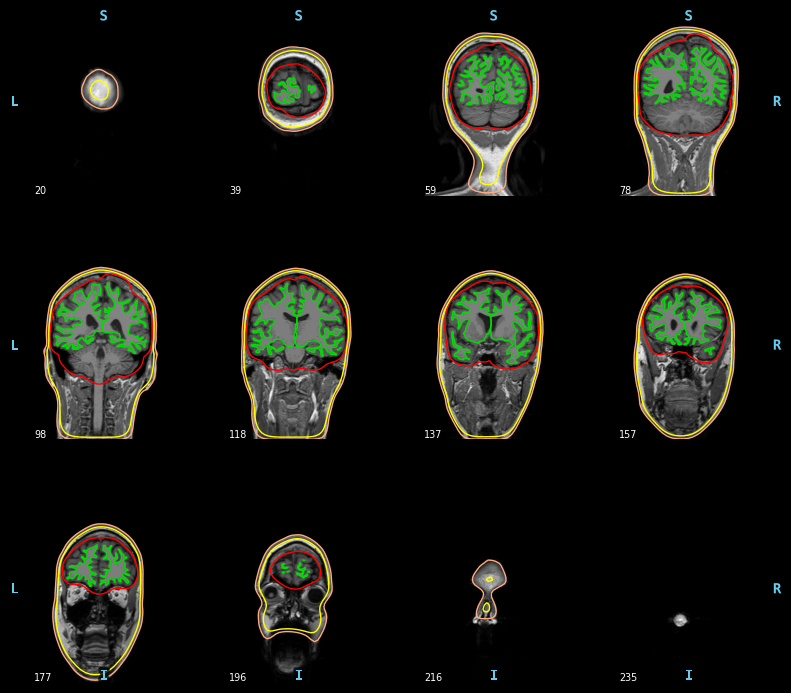

In [92]:
mne.viz.plot_bem(
    subject='s1_pac_sub43',
    subjects_dir=fs_subjects_dir,
    brain_surfaces='white',
    show=True
)


DRAFTING THE SCRIPT
1. Find optimal source reconstruction method
2. Inverse operator - on evoked (higher snr); sources - on epochs (for PAC)


LCMV

In [2]:
from mne.beamformer import apply_lcmv, make_lcmv, apply_lcmv_epochs
from mne.datasets import fetch_fsaverage, sample

In [20]:
subject = 's1_pac_sub24'
task = '_MAIN'
task_stage = '_go'
block_name = '_adaptation'
epochs_file = f'D:\\BonoKat\\research project\\# study 1\\eeg_data\\set\\Y\\{subject}\\preproc\\analysis\\{subject}{task}_epochs{task_stage}{block_name}-epo.fif'
epochs = mne.read_epochs(epochs_file)
epochs.apply_baseline(baseline=(-0.5, -0.001))

evoked = epochs.average()
evoked.plot()

# Compute data and noise covariance matrices
data_cov = mne.compute_covariance(epochs, tmin=0, tmax=0.5, method='auto', rank='info')
data_cov.plot(epochs.info)

noise_cov = mne.compute_covariance(epochs, tmin=-0.5, tmax=-0.001, method='auto', rank='info') # Use method='auto' when you want safe defaults for source localization and don't want to hand-tune covariance
noise_cov.plot(epochs.info)


Reading D:\BonoKat\research project\# study 1\eeg_data\set\Y\s1_pac_sub24\preproc\analysis\s1_pac_sub24_MAIN_epochs_go_adaptation-epo.fif ...
    Read a total of 1 projection items:
        Average EEG reference (1 x 60) active
    Found the data of interest:
        t =    -500.00 ...     700.00 ms
        0 CTF compensation matrices available
Adding metadata with 16 columns
180 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Applying baseline correction (mode: mean)
    Created an SSP operator (subspace dimension = 1)
    Setting small EEG eigenvalues to zero (without PCA)
Reducing data rank from 60 -> 59
Estimating covariance using SHRUNK
Done.
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Estimating covariance using EMPIRICAL
Done.
Using cross-validation to select the best estimator.
    EEG regularization : 0.1
    EEG regularization : 0.1
    EEG regularization : 0.1

(<Figure size 380x370 with 2 Axes>, <Figure size 380x370 with 1 Axes>)

In [21]:
diff = np.abs(noise_cov.data - data_cov.data)
print("Max difference:", np.max(diff))
print("Min difference:", np.min(diff))
print("Mean difference:", np.mean(diff))

Max difference: 1.8463190380593548e-11
Min difference: 8.672447470442512e-16
Mean difference: 3.313032890265921e-12


____________

In [22]:
fwd_fname = f'D:\\BonoKat\\research project\\# study 1\\eeg_data\\set\\Y\\{subject}\\preproc\\analysis\\source\\{subject}-fwd.fif'
forward = mne.read_forward_solution(fwd_fname)
# Convert to fixed orientation (normal to cortex) AFTER computing the forward model
fwd_fixed = mne.convert_forward_solution(forward, surf_ori=True, force_fixed=True)
fwd_fixed

Reading forward solution from D:\BonoKat\research project\# study 1\eeg_data\set\Y\s1_pac_sub24\preproc\analysis\source\s1_pac_sub24-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523 (FIFF_MNE_FORWARD_SOLUTION_GRAD)) not available
    Read EEG forward solution (5124 sources, 60 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]


EEG,60
Source space,Surface with 5124 vertices
Source orientation,Fixed


In [23]:
filters = make_lcmv(
    evoked.info,
    fwd_fixed,
    data_cov,
    reg=0.05,
    noise_cov=noise_cov,
    pick_ori=None,
    weight_norm="unit-noise-gain",
    rank=None,
)
filters
# You can save the filter for later use with:
# filters.save('filters-lcmv.h5')

Computing rank from covariance with rank=None
    Using tolerance 7.2e-14 (2.2e-16 eps * 60 dim * 5.4  max singular value)
    Estimated rank (eeg): 59
    EEG: rank 59 computed from 60 data channels with 1 projector
Computing rank from covariance with rank=None
    Using tolerance 4.8e-14 (2.2e-16 eps * 60 dim * 3.6  max singular value)
    Estimated rank (eeg): 59
    EEG: rank 59 computed from 60 data channels with 1 projector
Making LCMV beamformer with rank {'eeg': 59}
Computing inverse operator with 60 channels.
    60 out of 60 channels remain after picking
Selected 60 channels
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 1)
Computing rank from covariance with rank={'eeg': 59}
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing beamformer filters for 5124 sources
Filter computation complete


<Beamformer | LCMV, subject "s1_pac_sub24", 5124 vert, 60 ch, unit-noise-gain norm, matrix inversion, rank 59>

In [24]:
stc = apply_lcmv_epochs(epochs, filters)
stc

Processing epoch : 1
Processing epoch : 2
Processing epoch : 3
Processing epoch : 4
Processing epoch : 5
Processing epoch : 6
Processing epoch : 7
Processing epoch : 8
Processing epoch : 9
Processing epoch : 10
Processing epoch : 11
Processing epoch : 12
Processing epoch : 13
Processing epoch : 14
Processing epoch : 15
Processing epoch : 16
Processing epoch : 17
Processing epoch : 18
Processing epoch : 19
Processing epoch : 20
Processing epoch : 21
Processing epoch : 22
Processing epoch : 23
Processing epoch : 24
Processing epoch : 25
Processing epoch : 26
Processing epoch : 27
Processing epoch : 28
Processing epoch : 29
Processing epoch : 30
Processing epoch : 31
Processing epoch : 32
Processing epoch : 33
Processing epoch : 34
Processing epoch : 35
Processing epoch : 36
Processing epoch : 37
Processing epoch : 38
Processing epoch : 39
Processing epoch : 40
Processing epoch : 41
Processing epoch : 42
Processing epoch : 43
Processing epoch : 44
Processing epoch : 45
Processing epoch : 

[<SourceEstimate | 5124 vertices, subject : s1_pac_sub24, tmin : -500.0 (ms), tmax : 700.0 (ms), tstep : 2.0 (ms), data shape : (5124, 601), ~23.5 MB>,
 <SourceEstimate | 5124 vertices, subject : s1_pac_sub24, tmin : -500.0 (ms), tmax : 700.0 (ms), tstep : 2.0 (ms), data shape : (5124, 601), ~23.5 MB>,
 <SourceEstimate | 5124 vertices, subject : s1_pac_sub24, tmin : -500.0 (ms), tmax : 700.0 (ms), tstep : 2.0 (ms), data shape : (5124, 601), ~23.5 MB>,
 <SourceEstimate | 5124 vertices, subject : s1_pac_sub24, tmin : -500.0 (ms), tmax : 700.0 (ms), tstep : 2.0 (ms), data shape : (5124, 601), ~23.5 MB>,
 <SourceEstimate | 5124 vertices, subject : s1_pac_sub24, tmin : -500.0 (ms), tmax : 700.0 (ms), tstep : 2.0 (ms), data shape : (5124, 601), ~23.5 MB>,
 <SourceEstimate | 5124 vertices, subject : s1_pac_sub24, tmin : -500.0 (ms), tmax : 700.0 (ms), tstep : 2.0 (ms), data shape : (5124, 601), ~23.5 MB>,
 <SourceEstimate | 5124 vertices, subject : s1_pac_sub24, tmin : -500.0 (ms), tmax : 700

In [25]:
stc_ave = (sum(stc)/len(stc))
stc_ave

<SourceEstimate | 5124 vertices, subject : s1_pac_sub24, tmin : -500.0 (ms), tmax : 700.0 (ms), tstep : 2.0 (ms), data shape : (5124, 601), ~23.5 MB>

In [26]:
# src = forward["src"]
# lims = [0.3, 0.45, 0.6]
# kwargs = dict(
#     src=src,
#     subject="sample",
#     subjects_dir=subjects_dir,
#     initial_time=0.087,
#     verbose=True,
# )
mne.viz.set_3d_backend('pyvistaqt')  # or 'pyvista'

stc_ave.plot(
    hemi='both',
    background='black',  # or 'black' depending on your preference
    brain_kwargs=dict(
        cortex='low_contrast'
    )
)

Using control points [0.17669726 0.21711989 0.53257953]


In [286]:
evo_data = np.average(epochs.get_data(), axis=0)
evo_data.shape

(61, 601)

In [285]:
type(epochs.get_data())

numpy.ndarray

In [312]:
fig1 = plt.plot(evo_data[0])
plt.show()

In [311]:
fig2 = plt.plot(stc_ave.data[0, :])
plt.show()

PAC

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import mne
import os
from utils import check_paths
import pandas as pd
from scipy.io import loadmat
import joblib
import matplotlib.gridspec as gridspec

from pactools import Comodulogram, REFERENCES, raw_to_mask

from mne.channels.layout import find_layout
from functools import partial
from mne.defaults import _handle_default

from mne.viz.topo import _erfimage_imshow_unified, _plot_topo

from mne.viz.utils import (
    _setup_vmin_vmax,
    add_background_image
)
from collections import namedtuple

%matplotlib qt

In [ ]:
eeg_data_dir = 'D:\\BonoKat\\research project\\# study 1\\eeg_data\\set'
group = 'Y'
subs = os.listdir(os.path.join(eeg_data_dir, group))
tasks = ['_MAIN'] # ['_BL', '_MAIN']
task_stages = ['_plan', '_go'] # '_plan' or '_go'
block_names = ['_baseline', '_adaptation'] # ['_baseline', '_adaptation']


In [29]:
theta_range = np.linspace(4, 8, 20)  # Phase: 4-8 Hz
gamma_range = np.linspace(30, 80, 20)  # Amplitude: 30-80 Hz

In [31]:
stc_ave.data.shape

(5124, 601)

In [32]:
signal = stc_ave.data[0, :]
signal

array([-0.00624631, -0.00440542, -0.00399735, -0.00473514, -0.00599166,
       -0.00721596, -0.00828091, -0.00955405, -0.01161965, -0.01477318,
       -0.01862145, -0.02214187, -0.02428471, -0.02473294, -0.02413156,
       -0.0234404 , -0.02297175, -0.02208183, -0.01987278, -0.0163042 ,
       -0.0125714 , -0.01024377, -0.00990052, -0.01060813, -0.01077696,
       -0.00968082, -0.00805899, -0.00723958, -0.0077163 , -0.0086421 ,
       -0.00875901, -0.00782113, -0.0069604 , -0.00755421, -0.00974601,
       -0.01211753, -0.01298294, -0.01202495, -0.01066543, -0.01080169,
       -0.0129782 , -0.01569738, -0.0165626 , -0.01429655, -0.0099104 ,
       -0.00599622, -0.00472801, -0.00619867, -0.00835715, -0.00861479,
       -0.00585186, -0.0011851 ,  0.00301024,  0.00498206,  0.00476427,
        0.00371299,  0.00301886,  0.00267355,  0.00185554,  0.00019147,
       -0.00150286, -0.00191324, -0.00067113,  0.00095535,  0.00099769,
       -0.00136664, -0.00478793, -0.00656994, -0.00476006,  0.00

In [33]:
all_channels_data = epochs.get_data()
all_channels_data.shape

(180, 61, 601)

In [35]:
all_channels_data[:, 0].shape

(180, 601)

In [36]:
data_flat = np.reshape(all_channels_data[:, 0], -1)[None, :]
data_flat.shape

(1, 108180)

In [37]:
180*601

108180

In [47]:
print(len(stc))
print(stc[0].shape)

180
(5124, 601)


In [50]:
stc[0].data

array([[-0.06224161, -0.0896596 , -0.08384904, ..., -0.04185326,
        -0.02623498, -0.03421946],
       [-0.01568333,  0.01835822,  0.03297882, ...,  0.04174128,
         0.04492359,  0.04285481],
       [ 0.04295963,  0.02058345,  0.00066065, ...,  0.05067951,
         0.02516741, -0.00845364],
       ...,
       [-0.33633811, -0.36719852, -0.23637428, ...,  0.26568002,
         0.36353879,  0.4089792 ],
       [ 0.34645587,  0.31758672,  0.15701335, ..., -0.28840845,
        -0.38772092, -0.42065245],
       [-0.06209992, -0.10557966, -0.07429507, ...,  0.22048119,
         0.27686315,  0.30060433]])

In [52]:
source_list = [source.data for source in stc]
source_array = np.stack(source_list, axis=0)

print(source_array.shape)  # (180, 5124, 601)

(180, 5124, 601)


In [56]:
data_flat = np.reshape(source_array[:, 0], -1)[None, :]
data_flat.shape

(1, 108180)

In [59]:
sub_name = subject

In [60]:
# Crop epochs to the time window of interest
epo_tmin = 0.0
epo_tmax = [0.495 if task_stage == '_plan' else 0.695][0]
epochs.crop(tmin=epo_tmin, tmax=epo_tmax)
# epochs.pick(choi)
times = epochs.times

#Estimate PAC
estimator = Comodulogram(
    fs=epochs.info['sfreq'],
    low_fq_range=theta_range,  # Phase frequencies (theta)
    high_fq_range=gamma_range, # Amplitude frequencies (gamma)
    method='tort',
    progress_bar=True
    )

stc_data = stc_ave.data
pac_results = np.empty(
    (len(theta_range), stc_data.shape[1], len(gamma_range))
)


# for source_idx in range(stc_ave.data.shape[0]):
#     signal = stc_ave.data[source_idx, :]

for i in range(10):
    data_flat = np.reshape(source_array[:, i], -1)[None, :]
    pac = estimator.fit(
            data_flat,
            data_flat,
        )
    pac_results[:, i] = pac.comod_

    # Convert the plot to a Plotly figure (if supported)
    fig = pac.plot(tight_layout=False, cmap='magma')
    # Add a title
    plt.title(f"PAC MI {sub_name[-5:]} {i}: {task}{task_stage}{block_name}")

    # Save the plot
    plt.show()


[........................................] 100% | 1.90 sec | comodulogram: tort 
[........................................] 100% | 0.99 sec | comodulogram: tort 
[........................................] 100% | 0.95 sec | comodulogram: tort 
[........................................] 100% | 0.95 sec | comodulogram: tort 
[........................................] 100% | 0.95 sec | comodulogram: tort 
[........................................] 100% | 0.97 sec | comodulogram: tort 
[........................................] 100% | 0.96 sec | comodulogram: tort 
[........................................] 100% | 0.97 sec | comodulogram: tort 
[........................................] 100% | 0.96 sec | comodulogram: tort 
[........................................] 100% | 0.96 sec | comodulogram: tort 


STOPPED HERE

_____________________

SINGLE SUB ANALYSIS

Reading electrode locations

In [33]:
dig_folder = 'D:\\BonoKat\\research project\\# study 1\\dig_data\\files for analysis\\Y'
# subject = 'sub01_test'
dig_file = os.path.join(dig_folder, f"{subject}.txt")

# Set the header line
column_names = ['Electrode Name', 'Electrode Type', 'Session Name', 'Loc. X', 'Loc. Y', 'Loc. Z', 'm0n0', 'm0n1', 'm0n2', 'm1n0', 'm1n1', 'm1n2', 'm2n0', 'm2n1', 'm2n2']
cols_to_drop = ['m0n0', 'm0n1', 'm0n2', 'm1n0', 'm1n1', 'm1n2', 'm2n0', 'm2n1', 'm2n2']

# Load the data, skipping the header lines
dig_points_df = pd.read_csv(dig_file, names=column_names, sep='\t', comment='#').iloc[:-1]
dig_points_df.drop(columns=cols_to_drop, inplace=True) # Drop electrode orientaiton columns
dig_points_df['Electrode Type'] = dig_points_df['Electrode Type'].replace('Session 1', 'fiducial') # Set 'fiducial'as electrode type
dig_points_df = dig_points_df.drop(columns=['Session Name']) # Drop the 'Session Name' column
dig_points_df = dig_points_df.dropna() # Drop rows with any NaN values
dig_points_df

,Electrode Name,Electrode Type,Loc. X,Loc. Y,Loc. Z
0,PZ,EEG,9.0000,-82.7433,84.9290
1,AF7,EEG,-52.6085,64.5538,15.0691
2,F5,EEG,-64.1519,38.7953,34.8584
3,C5,EEG,-82.0651,-18.4729,42.4110
4,POZ,EEG,5.3253,-106.0596,53.6421
...,...,...,...,...,...
59,PO8,EEG,57.7311,-97.7802,3.4139
60,P2,EEG,40.5271,-76.4376,78.4701
64,LPA,fiducial,139.3335,55.8965,-170.3642
65,Nasion,fiducial,23.6860,41.4335,-158.2550


In [ ]:
# # ! IF BRAINSIGHT COREG WAS PERFORMED: Flip the X and Y coordinates
# dig_points_df['Loc. X'] = -dig_points_df['Loc. X']
# dig_points_df['Loc. Y'] = -dig_points_df['Loc. Y']

In [34]:
# Convert mm to m
dig_points_df[['Loc. X', 'Loc. Y', 'Loc. Z']] = dig_points_df[['Loc. X', 'Loc. Y', 'Loc. Z']].astype(float).values / 1000 

# EEG electrodes
eeg_df = dig_points_df[dig_points_df['Electrode Type'] == 'EEG']
eeg_pos = dict(zip(
    eeg_df['Electrode Name'],
    np.vstack([eeg_df['Loc. X'], eeg_df['Loc. Y'], eeg_df['Loc. Z']]).T
))

# Fiducials
fid_df = dig_points_df[dig_points_df['Electrode Type'] == 'fiducial']
fid_pos = {row['Electrode Name'].lower(): [row['Loc. X'], row['Loc. Y'], row['Loc. Z']]
           for _, row in fid_df.iterrows()}

# Lowercase the montage keys to match MNE style
montage_renamed = {
    k.strip().capitalize(): v for k, v in eeg_pos.items()
}
# Create montage
montage = mne.channels.make_dig_montage(
    ch_pos=eeg_pos,
    # nasion=fid_pos['nasion'], # removed fducials, since they do not allign with the positions of the electrodes
    # lpa=fid_pos['lpa'],
    # rpa=fid_pos['rpa'],
    coord_frame='head'  # 'mni_tal' / 'head' if Brainsight .txt file was used (preferable)
)


In [35]:
## SANITY CHECK
# Plot channels and fiducials

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for idx, row in dig_points_df.iterrows():
    x, y, z = row["Loc. X"], row["Loc. Y"], row["Loc. Z"]
    label = row["Electrode Name"]
    ax.scatter(x, y, z, marker='o')
    ax.text(x, y, z, label, color='red')  # label each point

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Electrode positions')

plt.show()


In [36]:
subject = 's1_pac_sub01'
epochs_file = f'D:\\BonoKat\\research project\\# study 1\\eeg_data\\set\\Y\\{subject}\\preproc\\analysis\\{subject}_MAIN_epochs_plan_baseline-epo.fif'
epochs = mne.read_epochs(epochs_file)
epochs.set_montage(montage, match_case=False)
epochs.info['dig']
epochs.save(f'D:\\BonoKat\\research project\\# study 1\\eeg_data\\set\\Y\\{subject}\\preproc\\analysis\\{subject}_MAIN_epochs_plan_baseline-epo_montage.fif', overwrite=True)

Reading D:\BonoKat\research project\# study 1\eeg_data\set\Y\s1_pac_sub01\preproc\analysis\s1_pac_sub01_MAIN_epochs_plan_baseline-epo.fif ...
    Read a total of 1 projection items:
        Average EEG reference (1 x 60) active
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 15 columns
50 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Overwriting existing file.
Overwriting existing file.


C:\Users\a1902989\AppData\Local\Temp\ipykernel_5644\1223354283.py:6: RuntimeWarning: This filename (D:\BonoKat\research project\# study 1\eeg_data\set\Y\s1_pac_sub01\preproc\analysis\s1_pac_sub01_MAIN_epochs_plan_baseline-epo_montage.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(f'D:\\BonoKat\\research project\\# study 1\\eeg_data\\set\\Y\\{subject}\\preproc\\analysis\\{subject}_MAIN_epochs_plan_baseline-epo_montage.fif', overwrite=True)


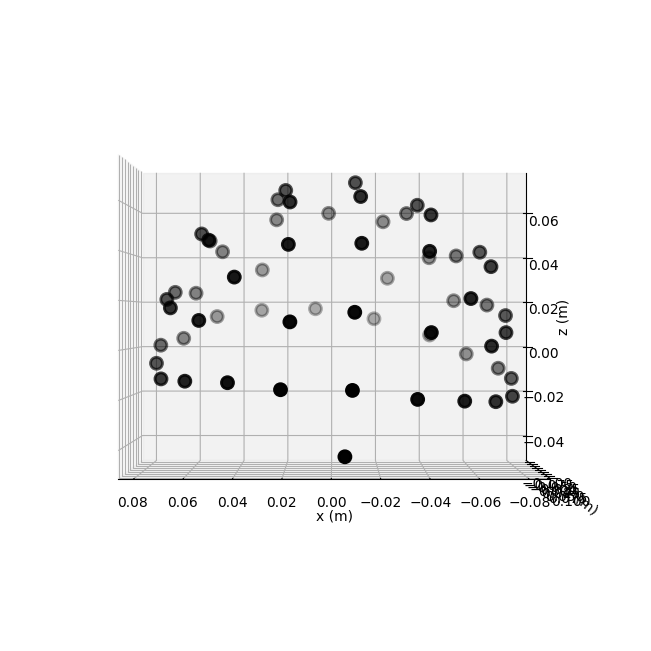

In [14]:
epochs.plot_sensors(kind='3d')

In [ ]:
subjects_dir = 'D:\\BonoKat\\research project\\# study 1\\mri_data\\fs_output\\freesurfer\\sub_dir\\Y'
info = f'D:\\BonoKat\\research project\\# study 1\\eeg_data\\set\\Y\\{subject}\\preproc\\analysis\\{subject}_MAIN_epochs_plan_baseline-epo_montage.fif'
mne.gui.coregistration(subject=subject,
                       subjects_dir=subjects_dir,
                       inst=info,
                    #    orient_to_surface=True,
                    #    scale_by_distance=True
                       )


Using high resolution head model in D:\BonoKat\research project\# study 1\mri_data\fs_output\freesurfer\sub_dir\Y\s1_pac_sub01\bem\s1_pac_sub01-head-dense.fif
    Triangle neighbors and vertex normals...
Using fiducials from: D:\BonoKat\research project\# study 1\mri_data\fs_output\freesurfer\sub_dir\Y\s1_pac_sub01\bem\s1_pac_sub01-fiducials.fif.
Using high resolution head model in D:\BonoKat\research project\# study 1\mri_data\fs_output\freesurfer\sub_dir\Y\s1_pac_sub01\bem\s1_pac_sub01-head-dense.fif
    Triangle neighbors and vertex normals...
Using fiducials from: D:\BonoKat\research project\# study 1\mri_data\fs_output\freesurfer\sub_dir\Y\s1_pac_sub01\bem\s1_pac_sub01-fiducials.fif.
Loading MRI fiducials from D:\BonoKat\research project\# study 1\mri_data\fs_output\freesurfer\sub_dir\Y\s1_pac_sub01\bem\s1_pac_sub01-fiducials.fif... Done!
Using s1_pac_sub01-head-dense.fif for head surface.
    1 BEM surfaces found
    Reading a surface...
[done]
    1 BEM surfaces read
Channel typ

Aligning using ICP
Start     median distance:   7.49 mm
  ICP  1  median distance:   7.34 mm
Fitting ICP - iteration 1
Channel types::	eeg: 60
  ICP  2  median distance:   7.68 mm
Fitting ICP - iteration 2
Channel types::	eeg: 60
  ICP  3  median distance:   6.57 mm
Fitting ICP - iteration 3
Channel types::	eeg: 60
  ICP  4  median distance:   7.23 mm
Fitting ICP - iteration 4
Channel types::	eeg: 60
  ICP  5  median distance:   7.49 mm
Fitting ICP - iteration 5
Channel types::	eeg: 60
  ICP  6  median distance:   7.44 mm
Fitting ICP - iteration 6
Channel types::	eeg: 60
  ICP  7  median distance:   7.42 mm
Fitting ICP - iteration 7
Channel types::	eeg: 60
End       median distance:   7.42 mm
Fitting ICP finished in 0.63 seconds and 7 iterations.


PLOT BEM SURFACES - optional

Using surface: D:\BonoKat\research project\# study 1\mri_data\fs_output\freesurfer\sub_dir\Y\s1_pac_sub01\bem\inner_skull.surf
Using surface: D:\BonoKat\research project\# study 1\mri_data\fs_output\freesurfer\sub_dir\Y\s1_pac_sub01\bem\outer_skull.surf
Using surface: D:\BonoKat\research project\# study 1\mri_data\fs_output\freesurfer\sub_dir\Y\s1_pac_sub01\bem\outer_skin.surf


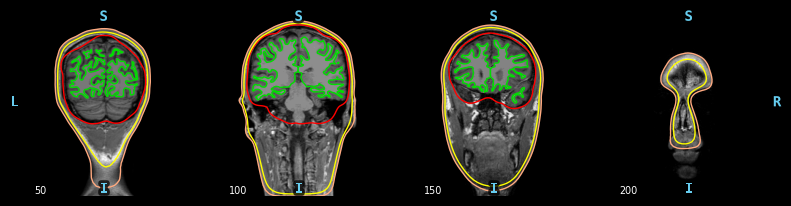

In [64]:
plot_bem_kwargs = dict(
    subject=subject,
    subjects_dir=fs_subjects_dir,
    brain_surfaces="white",
    orientation="coronal",
    slices=[50, 100, 150, 200],
)

mne.viz.plot_bem(**plot_bem_kwargs)

CHECK COREGISTRATION

In [ ]:
info = epochs.info
trans_file = f'D:\\BonoKat\\research project\\# study 1\\eeg_data\\set\\Y\\s1_pac_sub01\\preproc\\analysis\\{subject}-trans.fif'
trans = mne.read_trans(trans_file)
# Here we look at the dense head, which isn't used for BEM computations but
# is useful for coregistration.
mne.viz.plot_alignment(
    info,
    trans,
    subject=subject,
    dig=True,
    meg=["sensors"],
    subjects_dir=subjects_dir,
    surfaces=["head-dense"],
)

COMPUTE SOURCE SPACE

In [ ]:
# Set up the source space
src = mne.setup_source_space(
    subject, spacing="ico4", add_dist="patch", subjects_dir=subjects_dir
)
print(src)

Using surface: D:\BonoKat\research project\# study 1\mri_data\fs_output\freesurfer\sub_dir\Y\s1_pac_sub01\bem\inner_skull.surf
Using surface: D:\BonoKat\research project\# study 1\mri_data\fs_output\freesurfer\sub_dir\Y\s1_pac_sub01\bem\outer_skull.surf
Using surface: D:\BonoKat\research project\# study 1\mri_data\fs_output\freesurfer\sub_dir\Y\s1_pac_sub01\bem\outer_skin.surf


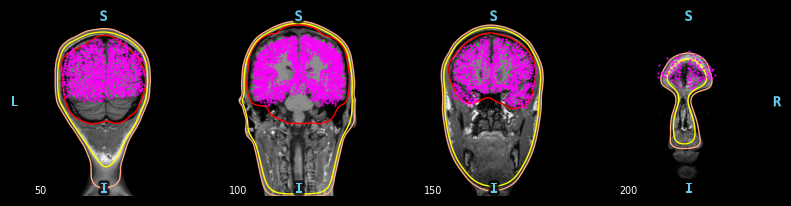

In [187]:
mne.viz.plot_bem(src=src, **plot_bem_kwargs)

In [225]:
fig = mne.viz.plot_alignment(
    subject=subject,
    subjects_dir=subjects_dir,
    surfaces="white",
    coord_frame="mri",
    src=src,
)
mne.viz.set_3d_view(
    fig,
    azimuth=173.78,
    elevation=101.75,
    distance=0.30,
    focalpoint=(-0.03, -0.01, 0.03),
)

In [ ]:
# BEM model
conductivity = (0.3, 0.006, 0.3)  # for three layers
model = mne.make_bem_model(
    subject=subject, ico=4, conductivity=conductivity, subjects_dir=subjects_dir
)
bem = mne.make_bem_solution(model)

In [ ]:
# Forward solution
fwd = mne.make_forward_solution(
    info,
    trans=trans,
    src=src,
    bem=bem,
    eeg=True,
    n_jobs=-1,
    # verbose=True,
)
print(fwd)

In [202]:
print(f"Before: {src}")
print(f'After:  {fwd["src"]}')

Before: <SourceSpaces: [<surface (lh), n_vertices=134495, n_used=2562>, <surface (rh), n_vertices=133726, n_used=2562>] MRI (surface RAS) coords, subject 's1_pac_sub01', ~25.3 MB>
After:  <SourceSpaces: [<surface (lh), n_vertices=134495, n_used=2562>, <surface (rh), n_vertices=133726, n_used=2562>] head coords, subject 's1_pac_sub01', ~25.3 MB>


___

! FOR EACH EPOCHS FILE

In [ ]:
# For each recording ! 
# Noise covariance matrix
noise_cov = mne.compute_covariance(epochs, tmax=0, method='empirical', rank=None) # method='empirical' for optimal regularisation
noise_cov.plot(epochs.info)

evoked = epochs.average()
evoked.plot_white(noise_cov, time_unit="s")

# Compute the inverse operator
inv = mne.minimum_norm.make_inverse_operator(info, fwd, noise_cov, loose=0.2)

# Compute the source estimates: on evoked data (!)
stc = mne.minimum_norm.apply_inverse(evoked, inv, lambda2=1. / 9.)
stc.plot()
